# <center>A Quantum Policy Gradient Agent</center>

In [1]:
import time, os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 
import tensorflow as tf
from keras import Input, layers, Model
import numpy as np
import gym

import matplotlib.pyplot as plt
from cirq.contrib.svg import circuit_to_svg
from IPython.display import HTML, SVG
from pyvirtualdisplay import Display

In [2]:
from utilities import train_agent, render, animation
from custom_layers import Scale, Circuit
from rl_algorithms import ActorCritic

<center>Create Gym Environment</center>

In [3]:
env = gym.make("CartPole-v1")

<center>Define Model Architecture</center>

In [4]:
num_layers = 7

inputs = Input(shape=env.observation_space.shape[0], dtype=tf.dtypes.float32, name='Input')
circuit = Circuit(num_layers)(inputs)
scaling = Scale()(circuit)

policy_logits = layers.Lambda(lambda x: x[:, ::2], name="Policy-Split")(scaling)  # Lambda conceals ugly slice in graph.
# value = layers.Lambda(lambda x: tf.reduce_prod(x[:, 1::2]), name="Value-Product")(scaling)
value = layers.Lambda(lambda x: x[:, 1] * x[:, 3], name="Value")(scaling)
policy = layers.Softmax(name="Policy")(policy_logits)

actor = Model(inputs=[inputs], outputs=policy, name="Actor")
critic = Model(inputs=[inputs], outputs=value,  name="Critic")
model = Model(inputs=[inputs], outputs=[policy, value], name="Actor-Critic")

model.summary()

Model: "Actor-Critic"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input (InputLayer)          [(None, 4)]                  0         []                            
                                                                                                  
 PQC (Circuit)               (None, 4)                    112       ['Input[0][0]']               
                                                                                                  
 Scaling (Scale)             (None, 4)                    4         ['PQC[0][0]']                 
                                                                                                  
 Policy-Split (Lambda)       (None, 2)                    0         ['Scaling[0][0]']             
                                                                                       

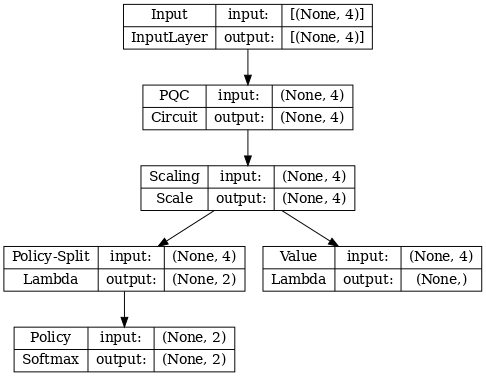

In [5]:
tf.keras.utils.plot_model(model, to_file="/tmp/model.png", show_shapes=True, dpi=70)

In [6]:
%%capture
circuit = circuit_to_svg(model.get_layer("PQC").circuit)

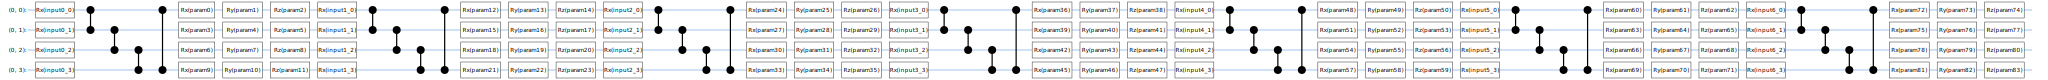

In [7]:
SVG(circuit)

<center>Train Model</center>

In [8]:
%%time

agent = ActorCritic(actor, critic, learning_rate=0.01, discount_factor=0.99)

def shaped_reward(reward, observation):
    position, pos_vel, angle, angle_vel = observation
    #return (1 - tf.abs(angle))
    return tf.exp(-tf.abs(angle))

state_bounds = np.array([2.4, 2.5, 0.21, 2.5]).astype(np.float32)
    
agent, total_rewards, episode_lengths = train_agent(env, agent, shaped_reward,
                                                    500, 5000, state_bounds,
                                                    (475, 100), True)

Episode: 693, Steps: 500, Average Episode Length: 473.7
Solved at Episode 694, Average Episode Length: 478.1

CPU times: user 56min 5s, sys: 6min 30s, total: 1h 2min 35s
Wall time: 30min 7s


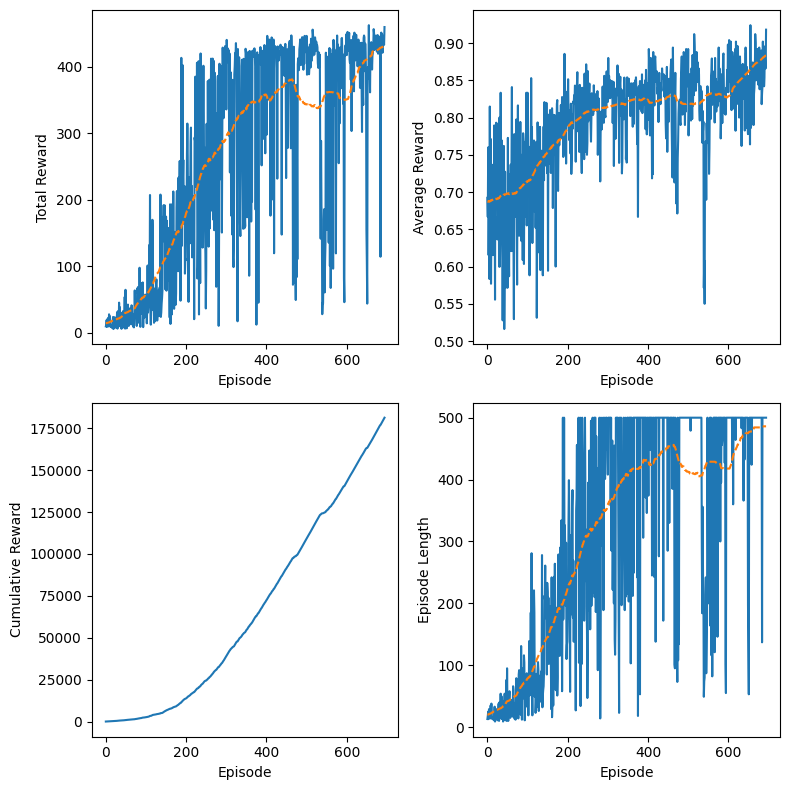

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

def smooth(s, alpha=0.2):
    averaging_length = int(len(s)*alpha)
    s = np.pad(s, (averaging_length//2, averaging_length//2), mode='edge')
    return np.convolve(s, np.ones(averaging_length)/averaging_length, mode='valid')

labels = ['Total Reward', 'Average Reward', 'Cumulative Reward', 'Episode Length']
data = [total_rewards, np.array(total_rewards) / episode_lengths, np.cumsum(total_rewards), episode_lengths]

for ax, label, data in zip(axes.flat, labels, data):
    ax.set_xlabel('Episode')
    ax.set_ylabel(label)
    ax.plot(data)
    if label != 'Cumulative Reward': ax.plot(smooth(data), '--')

fig.tight_layout()
plt.show()

In [10]:
vdisp = Display(visible=0, size=(500, 500)).start()

def action_fn(env, observation):
    observation = observation / state_bounds
    return agent.act(observation).numpy()

env = gym.make('CartPole-v1')
frames = render(env, action_fn, 500)
env.close()

HTML(animation(frames, len(frames)/24e-3).to_html5_video())

In [11]:
timestamp = time.strftime("%Y.%m.%d-%H.%M")
dirname = f'./QAC{timestamp}'
os.mkdir(dirname)
print(timestamp)

results = {"Total Reward":total_rewards, "Episode Length": episode_lengths}
np.save(f'{dirname}/results.npy', results)
agent.actor.save(f'{dirname}/actor.keras')
agent.critic.save(f'{dirname}/critic.keras')
model.save(f'{dirname}/actor-critic.keras')

./QAC2024.08.03-12.04
